In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import itertools
from noise_filter import *

# Path to the images
img_folder_noisy = "../Data/Week3/qsd1_w3/"  # Update this path as necessary
img_folder_gt = "../Data/Week3/qsd1_w3/non_augmented/"  # Update this path as necessary
list_noisy_img = [f for f in os.listdir(img_folder_noisy) if f.endswith('.jpg')]
list_gt_img = [f for f in os.listdir(img_folder_gt) if f.endswith('.jpg')]
list_noisy_img.sort()
list_gt_img.sort()

In [3]:
# Create a list that stores 1 if the image has noise, 0 if not.
pkl_path="../Data/Week3/qsd1_w3/augmentations.pkl"
with open(pkl_path, "rb") as f:
    data = pickle.load(f)
    
noise_label=[]
for label in data:
    if label == "UnnamedImpulseNoise":
        noise_label.append(1)
    else:
        noise_label.append(0)
print(noise_label)

[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]


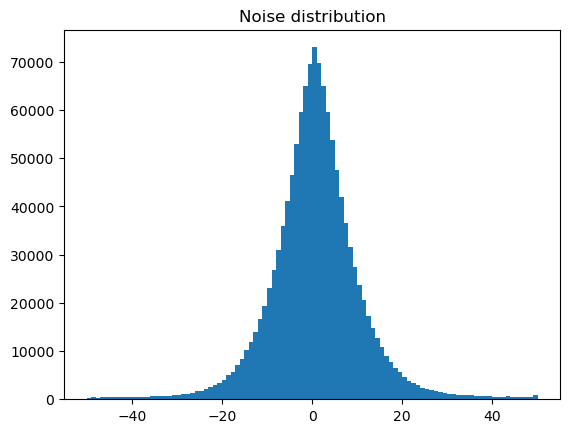

46.66167675683549
20.5664037499759
13.551162656204552


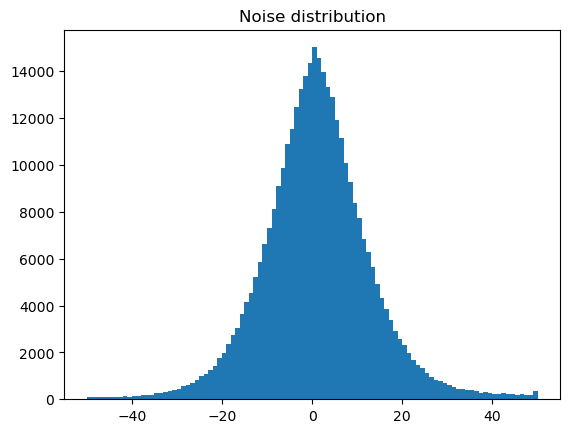

54.034671598237885
29.853495492906507
24.23517811530059


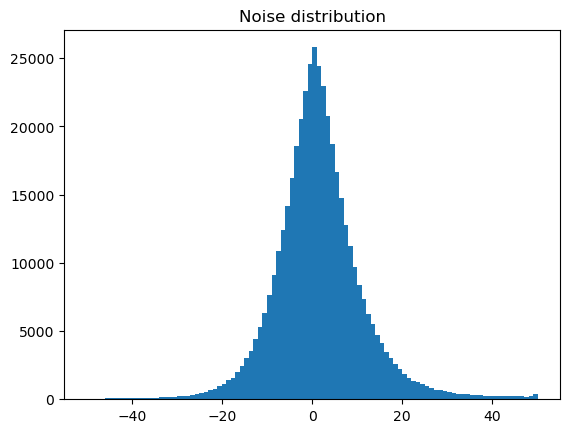

56.62228410581602
24.592893663278126
16.304320179458717


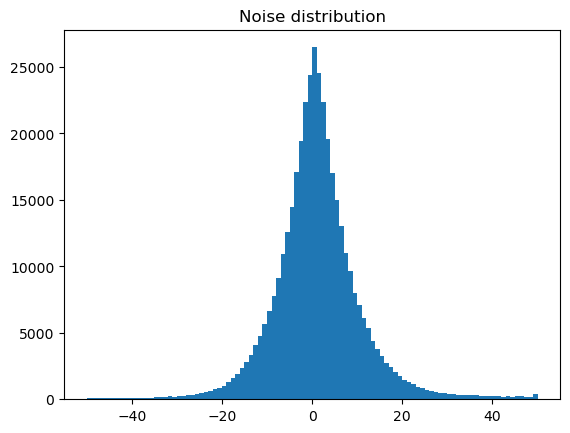

62.791172133367766
34.17471035407884
20.139256398639095


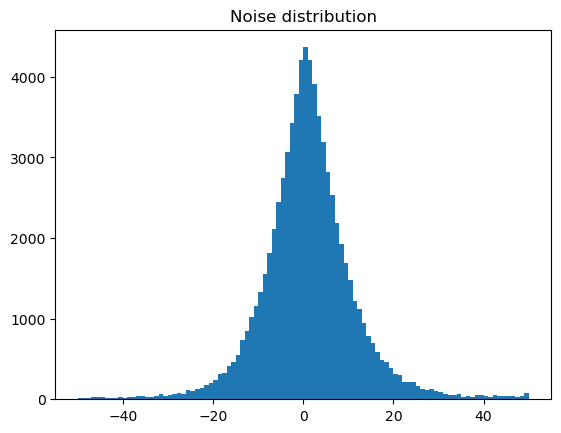

51.353997300818236
23.826485872559516
19.244788216426134


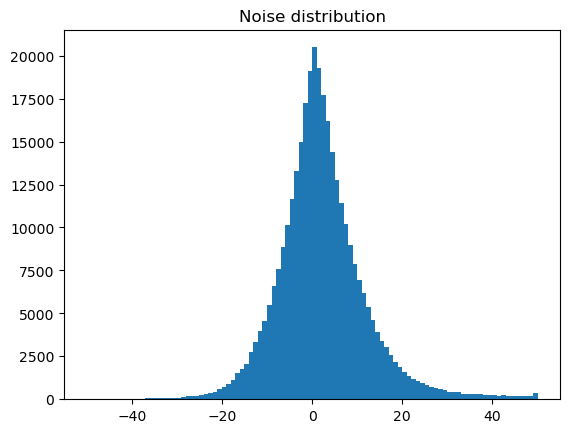

48.140860624205615
19.40457567539657
14.755251492203552


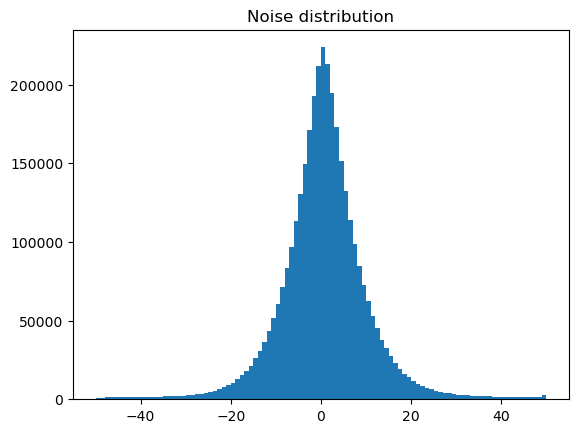

52.079578122282264
22.52071354513357
11.876388055838936


In [9]:
# List to store noise scores calculated in the frequency space
noise_score = []

for i_noisy, i_gt, n_label in zip(list_noisy_img, list_gt_img, noise_label):
    noisy_img = cv2.imread(os.path.join(img_folder_noisy, i_noisy))
    gt_img = cv2.imread(os.path.join(img_folder_gt, i_gt))
    
    noise_score.append(fourier_noise_score(noisy_img, radius_ratio=0.75))
    if n_label:
        analyze_noise(noisy_img, gt_img)
        print(fourier_noise_score(noisy_img, radius_ratio=0.75))
        denoised_img=remove_noise_median(noisy_img, ksize=3)
        print(fourier_noise_score(denoised_img, radius_ratio=0.75))
        denoised_img=remove_noise_nlmeans(denoised_img, h=5, templateWindowSize=3, searchWindowSize=21)
        print(fourier_noise_score(denoised_img, radius_ratio=0.75))

In [ ]:
# Now, threshold the noise_score to know which images have noise.
# For those with noise, perform the noise filter algorithm.
THRESHOLD = 40
mse_list, ssim_list = [], []
for score, n_img_path, gt_img_path in zip(noise_score, list_noisy_img, list_gt_img):
    if score > THRESHOLD:
        noisy_img = cv2.imread(os.path.join(img_folder_noisy, n_img_path))
        gt_img = cv2.imread(os.path.join(img_folder_gt, gt_img_path))
        #print(classify_noise_type(noisy_img)
        denoised_img=remove_noise_median(noisy_img, ksize=3)
        denoised_img=remove_noise_bilateral(denoised_img, d=21, sigmaColor=25, sigmaSpace=50)
        #denoised_img=remove_noise_nlmeans(denoised_img, h=5, templateWindowSize=3, searchWindowSize=21)
        # Calculate PSNR and SSIM
        m, ssim_val = evaluate_denoising(denoised_img, gt_img)
        print(mse_to_psnr(m), ssim_val)
        mse_list.append(m)
        ssim_list.append(ssim_val)
        cv2.imshow("", noisy_img)
        cv2.imshow("",denoised_img)
        cv2.waitKey(0)
#mean_mse = np.mean(mse_list)
#mean_ssim = np.mean(ssim_list)
#print(mean_mse, mean_ssim)

31.1131626055596 0.8597226751728364
23.562474485277164 0.6301769761623104


In [ ]:
# Define of parameters for grid search
"""h_values = [3, 5, 10]
template_sizes = [3, 5, 7]
search_sizes = [11, 15, 21]"""

d_values = [11, 15, 21]
sigmaColor_values = [25, 50, 100]
sigmaSpace_values = [50, 100, 200]

ksize=[3]

THRESHOLD = 40

results = []

#param_grid = list(itertools.product(h_values, template_sizes, search_sizes, ksize))
param_grid = list(itertools.product(d_values, sigmaColor_values, sigmaSpace_values, ksize))

for h, t, s, k in param_grid:
    mse_list, ssim_list = [], []

    for score, n_img_path, gt_img_path in zip(noise_score, list_noisy_img, list_gt_img):
        if score > THRESHOLD:
            noisy_img = cv2.imread(os.path.join(img_folder_noisy, n_img_path))
            gt_img = cv2.imread(os.path.join(img_folder_gt, gt_img_path))

            denoised_img = remove_noise_median(noisy_img, ksize=k)
            #denoised_img = remove_noise_nlmeans(denoised_img, h=h, templateWindowSize=t, searchWindowSize=s)
            denoised_img = remove_noise_bilateral(denoised_img, d=h, sigmaColor=t, sigmaSpace=s)
            
            
            m, ssim_val = evaluate_denoising(denoised_img, gt_img)
            mse_list.append(m)
            ssim_list.append(ssim_val)

    mean_mse = np.mean(mse_list)
    mean_ssim = np.mean(ssim_list)
    mean_psnr = mse_to_psnr(mean_mse)

    results.append({
        'h': h,
        'template': t,
        'search': s,
        'ksize': k,
        'mean_mse': mean_mse,
        'mean_ssim': mean_ssim,
        'mean_psnr': mean_psnr
    })

results_sorted = sorted(results, key=lambda x: (x['mean_psnr'], x['mean_ssim']), reverse=True)
best = results_sorted[0]

print("\nGrid search results:")
for r in results_sorted:
    print(f"h={r['h']}, template={r['template']}, search={r['search']}, ksize={r['ksize']} → "
          f"PSNR={r['mean_psnr']:.2f}, SSIM={r['mean_ssim']:.3f}")

print("\nBest set of parameters:")
print(f"h={best['h']}, template={best['template']}, search={best['search']}, ksize={r['ksize']}")
print(f"PSNR mean={best['mean_psnr']:.2f}, SSIM mean={best['mean_ssim']:.3f}")




Grid search results:
h=21, template=10, search=100, ksize=3 → PSNR=29.67, SSIM=0.832
h=21, template=10, search=50, ksize=3 → PSNR=29.67, SSIM=0.832
h=21, template=10, search=25, ksize=3 → PSNR=29.66, SSIM=0.832
h=21, template=25, search=25, ksize=3 → PSNR=29.65, SSIM=0.837
h=21, template=25, search=50, ksize=3 → PSNR=29.65, SSIM=0.836
h=21, template=25, search=100, ksize=3 → PSNR=29.65, SSIM=0.836
h=15, template=25, search=25, ksize=3 → PSNR=29.64, SSIM=0.835
h=15, template=25, search=50, ksize=3 → PSNR=29.64, SSIM=0.835
h=15, template=25, search=100, ksize=3 → PSNR=29.64, SSIM=0.835
h=11, template=25, search=50, ksize=3 → PSNR=29.57, SSIM=0.831
h=11, template=25, search=100, ksize=3 → PSNR=29.57, SSIM=0.831
h=11, template=25, search=25, ksize=3 → PSNR=29.57, SSIM=0.831
h=15, template=10, search=100, ksize=3 → PSNR=29.57, SSIM=0.827
h=15, template=10, search=50, ksize=3 → PSNR=29.57, SSIM=0.827
h=15, template=10, search=25, ksize=3 → PSNR=29.57, SSIM=0.827
h=11, template=10, search=10

In [ ]:
# noise_score ya contiene los valcommand:cellOutput.enableScrolling?b8c44762-98f0-4818-a0c9-b979ddd61aa6ores calculados por fourier_noise_score()
# noise_label debería ser 0 (sin ruido) o 1 (con ruido) para cada imagen

noise_score = np.array(noise_score)
noise_label = np.array(noise_label)  # asegúrate de que tenga la misma longitud

# 1️⃣ Visualizar las distribuciones separadas por tipo
plt.figure(figsize=(7,5))
plt.scatter(range(len(noise_score)), noise_score, c=noise_label, cmap='coolwarm', s=60)
plt.xlabel("Image index")
plt.ylabel("Fourier noise score")
plt.title("Noise score distribution (red = noisy, blue = clean)")
plt.colorbar(label="Label (0=clean, 1=noisy)")
plt.grid(True)
plt.show()

# 2️⃣ Opcional: histograma por grupo
plt.figure(figsize=(7,5))
plt.hist(noise_score[noise_label==0], bins=15, alpha=0.6, label="Clean")
plt.hist(noise_score[noise_label==1], bins=15, alpha=0.6, label="Noisy")
plt.xlabel("Noise score")
plt.ylabel("Number of images")
plt.title("Histogram of noise scores")
plt.legend()
plt.show()

# 3️⃣ Estimar threshold automáticamente (opcional)
# Por ejemplo, el punto medio entre las medias de ambos grupos
mean_clean = np.mean(noise_score[noise_label==0])
mean_noisy = np.mean(noise_score[noise_label==1])
threshold = (mean_clean + mean_noisy) / 2

print(f"Suggested threshold ≈ {threshold:.2f}")

# 4️⃣ Visualizar el threshold en el gráfico
plt.figure(figsize=(7,5))
plt.scatter(range(len(noise_score)), noise_score, c=noise_label, cmap='coolwarm', s=60)
plt.axhline(threshold, color='green', linestyle='--', label=f"Threshold = {threshold:.2f}")
plt.xlabel("Image index")
plt.ylabel("Noise score")
plt.title("Noise detection threshold visualization")
plt.legend()
plt.grid(True)
plt.show()
